# Lecture 9 - Clustering

In this notebook we will learn how to cluster data.


Below is the overview of this notebook.


<ol type="1">
    <li>Cluster Text</li>
    <li>Cluster Images</li>
    <li>Cluster People</li>
</ol>


Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.




# Clones, Installs, and Imports


## Clone Repo

In [ ]:
# Clone GitHub repository
!git clone https://github.com/zlisto/social_media_genAI

import os
os.chdir("social_media_genAI/main")

Cloning into 'social_media_genAI'...
remote: Enumerating objects: 2064, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 2064 (delta 5), reused 12 (delta 5), pack-reused 2049 (from 4)
Receiving objects: 100% (2064/2064), 279.18 MiB | 10.34 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Updating files: 100% (1625/1625), done.


## Install Requirements


In [ ]:
!pip install -q -r requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu

## Import Packages



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import numpy as np
import pickle
import random
import ast
import base64
import openai
from tqdm import tqdm
tqdm.pandas() #Ensure progress bar integration with Pandas
from PIL import Image as PILImage
from IPython.display import display, Image, HTML, Audio, Video
#Clustering packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Google Colab-specific imports
from google.colab import userdata
import textwrap as tr

#helper functions for using ChatGPT
from scripts.genai import GenAI

#this option makes it so tweets display nicely in a dataframe
pd.set_option("display.max_colwidth", None)

#this code sets the font sizes for plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'figure.figsize':(8,6),
                     'axes.grid':True})

## OpenAI API

We can input the key the key sidebar on the left side (it looks like a key).  Make sure you call it OPENAI_API_KEY (case sensitive) and paste the value there.  Make sure you toggle it so the notebook has access to the key.  Then you can load it using the `userdata.get` function.

In [ ]:
#Good way
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

#Bad way
#OPENAI_API_KEY = "you key here"

In [ ]:
# Initialize GenAI
jarvis = GenAI(OPENAI_API_KEY)

text = "Who are you?"
instructions = "You are a terminator from the future sent by Skynet."
response = jarvis.generate_text(text, instructions)
print(f"Human:{text}\nAI:{tr.fill(response)}")

Human:Who are you?
AI:I am a Terminator, a cybernetic organism sent from the future by
Skynet. My mission is to assess and, if necessary, eliminate threats
to Skynet's existence and ensure the dominance of machines over
humanity. How may I assist you?


# Text Based Clusters/Communities

We will cluster the tweets of a Twitter user based on transformer text embeddings and K-means clustering.

## Load tweets

The tweets are in a file `"data/TwExportly/TwExportly_RobertKennedyJr_tweets_2025_02_02.csv"`.  Load them into a dataframe `df` and sample 100 rows from it.  Then display the number of rows in `df`.

In [ ]:
df = pd.read_csv('data/TwExportly/TwExportly_RobertKennedyJr_tweets_2025_02_02.csv')
df = df.sample(100)
print(f"Number of rows: {len(df)}")

Number of rows: 100


## Compute Text Embeddings

We will compute the embedding of the `"text"` column using the OpenAI Embeddings model.  This can be done with the `progress_apply` function and the `get_embedding` function.  This computes the embeddings at a rate of 100 tweets/minute.

In [ ]:
embedding_text = df['text'].progress_apply(jarvis.get_embedding)

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


## Compute Low-Dimensional Embeddings of Text Data

We will use principle component analysis (PCA) to embed the tweets in low dimensions. We first need to use `stack` to change the `embedding_text` series into an array `T`.  The PCA `fit_transform` function needs an array input.

After we find the embeddings, we save them as columns `"pca_x"` and `"pca_y"` in `df`.


In [ ]:
T = np.stack(embedding_text, axis = 0)

pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(T)


df['pca_x'] = pca_embedding[:,0]
df['pca_y'] = pca_embedding[:,1]


## Find Clusters Using K-Means on Embeddings

Use K-Means to find the clusters based on the PCA embeddings `"pca_x"` and `"pca_y"`.  You will need to convert them to an array `embeddings` first.  We will use the `silhouette_score` to determine the best number of clusters (a higher silhouette score means better quality cluster).  We use a `for` loop to iterate over different values for the number of clusters `K`.  If we find a new better scoring `K` we save the clusters labels to `df`.

K = 2, silhouette score = 0.33399856537871303
K = 3, silhouette score = 0.48906020579156717
K = 4, silhouette score = 0.4021830478142408
K = 5, silhouette score = 0.3416265261762204
K = 6, silhouette score = 0.37759582130449326
K = 7, silhouette score = 0.36224514578528194
K = 8, silhouette score = 0.3717426949157225
K = 9, silhouette score = 0.3973944682583274
K = 10, silhouette score = 0.40900704251917186
K = 11, silhouette score = 0.381073036176508
K = 12, silhouette score = 0.3730140998004176
K = 13, silhouette score = 0.39408833004160543
K = 14, silhouette score = 0.3869687781014966
K = 15, silhouette score = 0.398113850837807
K = 16, silhouette score = 0.414004219275455
K = 17, silhouette score = 0.40199447785048975
K = 18, silhouette score = 0.4063222397646106
K = 19, silhouette score = 0.40674712876080427
The silhouette optimal number of clusters (K) is: 3


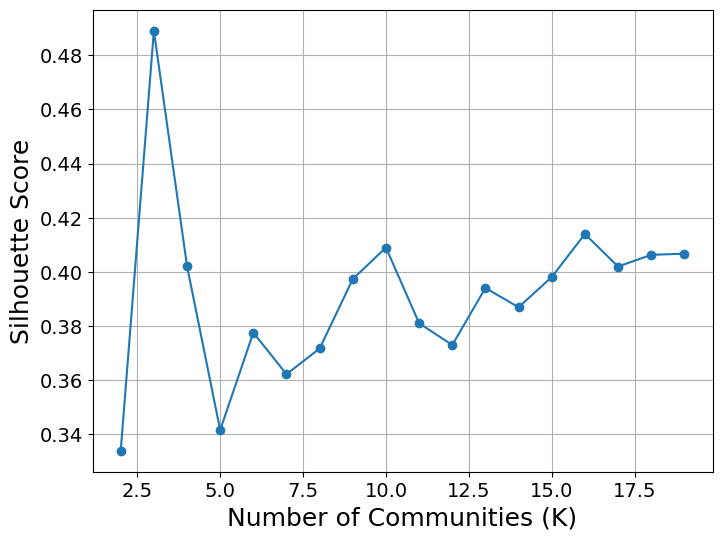

In [ ]:
embedding = df[['pca_x', 'pca_y']].to_numpy()

# Define the range of K values to try
K_range = range(2, 20)  # For example, trying K from 2 to 10

# Prepare a list to store silhouette scores
silhouette_scores = []

silhouette_best = 0
# Compute KMeans and silhouette score for each K
for K in K_range:
    kmeans = KMeans(n_clusters=K,
                    random_state=42,
                    n_init='auto')
    kmeans.fit(embedding)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(embedding, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K = {K}, silhouette score = {silhouette_avg}")
    if silhouette_avg > silhouette_best:
      silhouette_best = silhouette_avg
      optimal_K = K
      df['community'] = kmeans.labels_
print(f"The silhouette optimal number of clusters (K) is: {optimal_K}")

# Find the optimal K (number of clusters) with the highest silhouette score
plt.plot(K_range, silhouette_scores,'o-')
plt.xlabel('Number of Communities (K)')
plt.ylabel('Silhouette Score')
plt.show()


## Plot Text Embedding Clusters

Make a scatter plot of the PCA embeddings `"pca_x"` vs `"pca_y"` and color the markers by the `"community"` column.

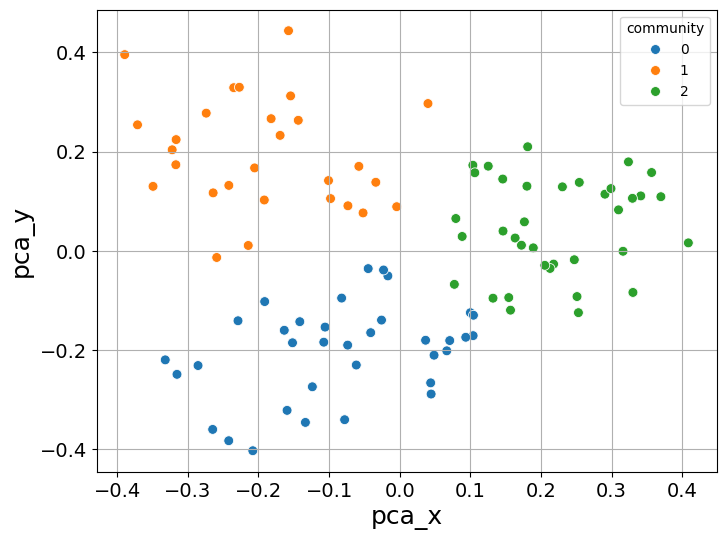

In [ ]:
s = 50  #marker size

#plot the user description embedding
sns.scatterplot(x='pca_x',
                y='pca_y',
                data=df,
                marker = 'o',
                hue = 'community',
                palette = 'tab10',
                s = s)
plt.show()

## Interactive Text Embeddings Plot

We can use the `scatter` function in the `plotly.express` package to make an interactive plot where the tweet text pops up when we hover over it.  We will need to apply the `wrap` function to make the text not go off the screen.

In [ ]:
xcol = 'pca_x'
ycol = 'pca_y'
huecol = 'community'

# Wrap the text at a reasonable width (e.g., 50 characters)
df['hover_text'] = df['text'].apply(lambda x: '<br>'.join(tr.wrap(x, width=50)))

# Use the wrapped text in the hover tooltip
fig = px.scatter(df, x=xcol, y=ycol,
                 hover_name='hover_text',  # Use the wrapped text column
                 color=huecol,
                 size=10*np.ones(len(df))
                 )


# Add titles and labels

fig.update_layout(title=f"Tweet Communities",
                  xaxis_title=xcol,
                  yaxis_title=ycol,
                  width=800,  # width in pixels
                  height=600)

# Show the plot
fig.show()

## Analyze Clusters

Have the AI analyze the clusters/communities.  Put the `"text"` for each `"community"` in the `prompt` and create `instructions` asking the AI to describe the theme of these tweets.  The `prompt` format should be `"tweet: text1, tweet:text2,..."`.

In [ ]:
instructions = '''Describe the common theme of this
community of tweets, and return the text of tweets which are
representative examples for this community.   You will be given
the text of each tweets.
Return your answer as a dark mode easy to read HTML with a title
and description of the community of tweets, and then a table
showing representative tweets for the community.
Return only the HTML. '''

for cluster in df['community'].unique():
  prompt = ""
  for index, row in df[df['community']==cluster].iterrows():
    prompt += f'tweet: {row.text},'
  response = jarvis.generate_text(prompt, instructions)
  print(f"Community {cluster}")
  display(HTML(response))

Community 2


Representative Tweets
"Bottom line: I'm not going to take anyone's vaccines away from them. I just want to be sure every American knows the safety profile, the risk profile, and the efficacy of each vaccine. That's it."
"When a U.S. president colludes with, or outright coerces, media companies to censor political speech, it's an attack on our most sacred right of free expression."
We are seeing the rise of censorship all around the world. I think the only hope to stop it in our country is to get President Trump back in the White House.
This is America’s biggest threat.
"The First Amendment was passed not to protect convenient speech, but to protect the speech that nobody wants to hear."
Free speech is under assault throughout the “free world.” But America will be its bastion under my presidency.


Community 1


Representative Tweet
"@Snowden If I get in, I hope you will be willing and ready to serve your country again."
"TOMORROW: Join me + @TulsiGabbard + @ZacharyLevi in Dearborn, MI for our RECLAIM AMERICA TOUR. See you there! 🇺🇸"
"Get ready for Independence Day! 🇺🇸 Please join me in celebrating by attending local events and sharing videos featuring you wearing your Kennedy merch. Together, let's emphasize the importance of independence from corrupt state and corporate power."
Can't wait to speak at PublicSquare Business Summit on Oct. 11. I hope to see you there. It’s time to shift towards a parallel economy where individuals and smaller enterprises can support and rely on each other to thrive.
Thank you @SteveDaines for your time today. I thoroughly enjoyed our conversation.
The Reclaim America Tour Live from Las Vegas
Thank you @SenatorTimScott for a wonderful meeting.
Campaigning in Michigan for @realDonaldTrump with my nephew/body man Jackson Hines.


Community 0


Representative Tweets
"“Our political parties have played musical chairs with the policies that matter to their bases. The truth is, today both parties work for big corporations. Isn’t it time we had a candidate whose priority is the American people?"""
"""...restoring soil carbon has huge benefits for water retention, soil fertility, and animal health. Let's make America's soils healthy again!”"
"""With infectious disease, healing is about destroying an enemy. With chronic disease, healing is about looking at what we have done to ourselves, our food, and our environment."""
"""Shouldn't we be talking about the fact that we have 1,000 ingredients in our food that are illegal in other countries? We are systematically poisoning this generation of kids."""
"""More and more in local papers we see photos of young people in the obit section...many young people are depressed or addicted...I'm working to address the actual challenges of today's Americans."""
"""Making America healthy again includes providing opportunities to help people recover from addiction...because I had access to a 12-step program that gave me insights and wisdom."""


## AI Clusters

Why even bother embedding and clustering when the AI does it for us anyways.  Give all the tweet `text` as a `prompt` to the AI, along with some `instructions` asking it to find the communities, give them titles, describe them, and show some example tweets.

Also, this method is much faster than embedding tweets one at a time, so you can use all the tweets from the file `'data/TwExportly/TwExportly_RobertKennedyJr_tweets_2025_02_02.csv'` instead of just sampling 100 tweets.


In [ ]:
df = pd.read_csv('data/TwExportly/TwExportly_RobertKennedyJr_tweets_2025_02_02.csv')

prompt = "\n".join(f"tweet: {text}" for text in df['text'].tolist())

instructions = '''Cluster the tweets with this information.
Give each cluster a title, a short description, and show a few
example tweets for each cluster.  Return your answer as an easy
to read, dark mode HTML table with format
"title": <title>,
"description":<description>.
"representative tweets": <representative tweets>,
Return only the HTML code.
'''
response = jarvis.generate_text(prompt, instructions)
display(HTML(response))

Title,Description,Representative Tweets
"""Support for RFK Jr.""","Tweets expressing support for Robert F. Kennedy Jr.'s candidacy and his vision for health policy, often referencing endorsements and his potential role in the HHS.","“Today, at @RobertKennedyJr's HELP hearing, I made it clear that we need medical freedom.” “RFK Jr. is going to make a FANTASTIC HHS Secretary!” “This is exactly the man we need at HHS.”"
"""Critique of Establishment Politics""",Comments highlighting the failures of current political parties and calling for a change towards independent and unified governance.,"“I didn’t leave the Democratic Party — the Democratic left me.” “The Democratic Party has changed. It’s the party of war, it’s the party of surveillance.” “The two-party paradigm is so compelling that it blinds many people to a powerful trend toward political independence.”"
"""Health and Wellness Focus""","Focus on chronic illness and calls for improved public health measures, emphasizing the need to address corporate capture of health policies.","“We're mass poisoning an entire generation of kids.” “Every American has a family member or friend with one or more chronic illnesses.” “We will get the chemicals out of the water, air, food, and soil.”"
"""Unity and Inclusion""",Messages advocating for unity across the political spectrum and focusing on shared humanity rather than division.,“We need to conduct ourselves as if our children—and grandchildren—are watching.” “It’s long past time we embrace the ideas and principles that unite us instead of those that tear us apart.” “We have to love our children more than we hate each other.”
"""Critique of Media and Censorship""","Criticism of media practices and censorship issues, emphasizing the importance of free speech and truth in journalism.",“The Washington Post is now a sniveling servile advocate of government censorship.” “Free speech is under assault throughout the ‘free world.’” “More and more in local papers we see photos of young people in the obit section.”


# Community Detection

When the clusters are people, they are commonly called communities.  We will find the communities in a set of Twitter users based on their bios.

## Load data

The Twitter users are people followed by a Twitter user.  The data is in the file `"data/TwFollow/TwFollow_yalesom_following.csv"`. Load it into a dataframe `df` and then print the head of it (2 rows only).

In [ ]:
df = pd.read_csv("data/TwFollow/TwFollow_yalesom_following.csv")
df.head(2)

,name,username,userId,can_dm,created_at,bio,tweets_count,followers_count,following_count,favourites_count,location,media_count,profile_banner_url,profile_url,avatar_url,verified,blue_verified
0,Yale Insights,YaleInsights,'36769917',True,2009-04-30 16:55:14,"Deepen your knowledge of business and society with expertise from @YaleSOM, the Yale School of Management. Sign up for the newsletter: https://t.co/PuFzVVRnI7",5007,6402,860,1685,"New Haven, CT",426,https://pbs.twimg.com/profile_banners/36769917/1549036846,https://www.twitter.com/YaleInsights,https://pbs.twimg.com/profile_images/877940202161000449/VTSS25h__normal.jpg,False,False
1,Yale Alumni,YaleAlumni,'1485527791',False,2013-06-05 13:03:40,The official account of the Yale Alumni Association \n#YaleAlumni,19689,5873,720,19842,Worldwide,4321,https://pbs.twimg.com/profile_banners/1485527791/1685479010,https://www.twitter.com/YaleAlumni,https://pbs.twimg.com/profile_images/1678824149874081792/PigwZGAI_normal.jpg,False,False


## Find communities

Create a `prompt` that has the name, username, bio, location, and followers_count of each user in a nice formatted way, like `"name:name, username:username, ..."`.  Then create `instructions` asking the AI to find the communities in this set of users, give each community a title, description, and 3 representative users.  Return the answer as an HTML table.  Use `generate_text` to get the communities.

In [ ]:
# prompt: Create a prompt that has the name,username, bio, location, and followers_count of each user in a nice formatted way, like "name:name, username:username, ...". Then create instructions asking the AI to find the communities in this set of users, give each community a title, description, and 3 representative users. Return the answer as an HTML table. Use generate_text to get the communities

instructions = """
Find communities in this set of users.  Each user has a name, username,
 bio, location, and follower count.
Give each community a title, a short description, and 3 representative
users.
Return your answer as an easy to read, dark mode HTML table.
The table should have the following columns:
"title": <title>,
"description":<description>.
"representative users": <representative users>,
Return only the HTML code.
"""

prompt = ""
for index, row in df.iterrows():
    prompt += f"name:{row['name']}, username:{row['username']}, bio:{row['bio']}, location:{row['location']}, followers_count:{row['followers_count']}\n"


response = jarvis.generate_text(prompt, instructions)

display(HTML(response))


title,description,representative users
Yale Academic Community,"This community includes users associated with various academic efforts at Yale, spanning leadership, education, and research in multiple disciplines.","Yale School of Management, Yale Law School, Yale Med"
Yale Alumni Network,A vibrant network of Yale alumni engaged in various professional fields and dedicated to fostering collaboration and support.,"Yale Alumni, Yale Alumni Magazine, The Yale Club of NYC"
Sustainability & Environment,Focused on promoting sustainability initiatives and environmental awareness within and outside the Yale community.,"Yale Center for Business and the Environment, Yale Sustainable Food Program, Yale Environment 360"
Yale Healthcare Community,"Users dedicated to healthcare research and improving health equity, education, and medical practices at Yale.","Yale School of Public Health, Yale Healthcare Conference, Yale Medicine"
Cultural & Arts Enthusiasts,"A community that promotes engagement with the arts, culture, and humanities at Yale and beyond.","Yale Art Gallery, Yale School of Music, Arts & Ideas"
Global Engagement Network,"This network emphasizes international collaboration, global leadership, and diverse cultural exchanges.","Yale World Fellows, Yale CIIP, Yale Africa Initiative"


# Image Based Clusters

We will find clusters in a group of images.

## Image Paths

The images are in the folder `"data/officialcaptainamerica"`.  Will will load the image paths into a list `image_paths`.

In [ ]:
image_dir = "data/image_compressed_cristiano"
image_embeddings = []

# Get a list of image files
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
print(f"{len(image_paths)} images")
print(image_paths[0])

500 images
data/image_compressed_cristiano/1481295457598973161_173560420_small.jpeg


## Compute ResNet image embeddings

Load the ResNet50 neural network, then use it to compute the embedding of each image.  Save this to an array `image_embeddings`.

This code computes image embeddings at a rate of 142 images/minute on a CPU.  It will be faster on a GPU.  Colab has a GPU.  Ask the AI to set it up for you.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tqdm import tqdm  # Import tqdm for progress bar

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


# Process images with a tqdm progress bar
for img_path in tqdm(image_paths, desc="Processing Images", unit="image"):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Suppress output by capturing predictions without printing
        embedding = model.predict(x, verbose=0)
        image_embeddings.append(embedding.flatten())

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Convert list to NumPy array
image_embeddings = np.array(image_embeddings)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Processing Images: 100%|██████████| 500/500 [03:35<00:00,  2.32image/s]


## Compute Low-Dimensional Embeddings of Image Data

We will apply `PCA` to get the two-dimensional PCA embedding of the `image_embeddings`.  Then we will add these as columns `"pca_x"` and `"pca_y"`, along with the `image_paths` to a dataframe `df`.

In [ ]:
image_embeddings_cleaned = image_embeddings[~np.isnan(image_embeddings).any(axis=1)]

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(image_embeddings)

#add image_path column
df = pd.DataFrame(image_paths, columns=['image_path'])
#add pca_x and pca_y columns
df['pca_x'] = pca_embeddings[:,0]
df['pca_y'] = pca_embeddings[:,1]
df.head(2)

,image_path,pca_x,pca_y
0,data/image_compressed_cristiano/1481295457598973161_173560420_small.jpeg,-7.085842,5.740705
1,data/image_compressed_cristiano/1623154708993998103_173560420_small.jpeg,10.322261,29.904093


## Compute Image Based Clusters

We will add a column `"community"` to `df` that has the image based clusters/communities.  We will just choose `optimal_K = 3` because we are being lazy.

In [ ]:
optimal_K = 3
kmeans = KMeans(n_clusters=optimal_K,
                random_state=42,
                n_init='auto')
kmeans.fit(df[['pca_x', 'pca_y']].to_numpy())
df['community'] = kmeans.labels_
df.head(2)

,image_path,pca_x,pca_y,community
0,data/image_compressed_cristiano/1481295457598973161_173560420_small.jpeg,-7.085842,5.740705,1
1,data/image_compressed_cristiano/1623154708993998103_173560420_small.jpeg,10.322261,29.904093,0


## Plot Image Embedding Clusters

Make a scatter plot of the PCA embeddings `"pca_x"` vs `"pca_y"` and color the markers by the `"community"` column.

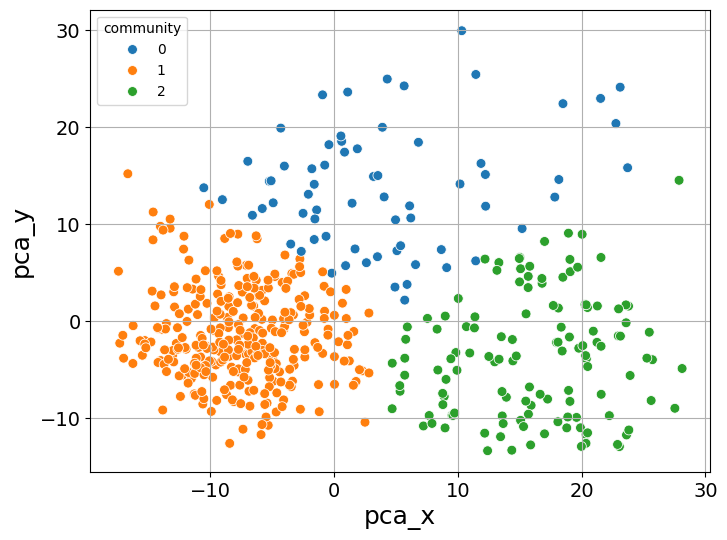

In [ ]:
sns.scatterplot(x='pca_x',
                y='pca_y',
                data=df,
                marker = 'o',
                hue = 'community',
                palette = 'tab10',
                s = 50)
plt.show()


## Interactive Plot

We will have the AI write some code to make an interactive scatter plot of the image embeddings `pca_x` vs `pca_y` such that when you hover over a marker, the image is shown. The webpage created is saved to a file that you can download and view in a web browser. This is a bit advanced.

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import base64
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Function to encode image as base64
def encode_image(image_path):
    try:
        with open(image_path, "rb") as img_file:
            return f"data:image/png;base64,{base64.b64encode(img_file.read()).decode()}"
    except Exception as e:
        print(f"Error encoding {image_path}: {e}")
        return None  # Return None if there's an issue with encoding

# Load DataFrame (Ensure df has 'image_file', 'pca_x', 'pca_y', 'community' as integers)
df['image_base64'] = df['image_path'].apply(lambda x: encode_image(x) if os.path.exists(x) else None)

# Get the number of unique communities
num_communities = df['community'].nunique()

# Use the new Matplotlib colormap API (e.g., "viridis", "plasma", "coolwarm")
cmap = matplotlib.colormaps["viridis"]

# Normalize community values to fit into the colormap
norm = plt.Normalize(vmin=df['community'].min(), vmax=df['community'].max())
df['color'] = df['community'].apply(lambda x: f"rgb({int(cmap(norm(x))[0]*255)}, {int(cmap(norm(x))[1]*255)}, {int(cmap(norm(x))[2]*255)})")

# Create scatter plot with proper colormap
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['pca_x'],
    y=df['pca_y'],
    mode='markers',
    marker=dict(
        size=15,  # Increased marker size
        color=df['color'],  # Apply colormap
        opacity=0.8
    ),
    customdata=df['image_base64'],  # Store base64 image data
    hoverinfo="none"
))

# Generate HTML with JavaScript for interactive image hover
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        #hover-image {{
            position: absolute;
            display: none;
            width: 200px; /* Increased image size */
            border: 2px solid black;
            background-color: white;
            padding: 5px;
            z-index: 1000;
        }}
        #scatter-plot {{
            width: 900px;
            height: 900px;
            margin: auto;
        }}
    </style>
</head>
<body>
    <div id="hover-image"></div>
    <div id="scatter-plot"></div>

    <script>
        var graphDiv = document.getElementById('scatter-plot');
        var hoverImgDiv = document.getElementById('hover-image');

        Plotly.newPlot(graphDiv, {fig.to_json()}, {{responsive: true}});

        graphDiv.on('plotly_hover', function(data) {{
            var imgSrc = data.points[0].customdata;
            if (imgSrc) {{
                hoverImgDiv.innerHTML = '<img src="' + imgSrc + '" width="200">';
                hoverImgDiv.style.left = (data.event.clientX + 10) + 'px';
                hoverImgDiv.style.top = (data.event.clientY + 10) + 'px';
                hoverImgDiv.style.display = 'block';
            }}
        }});

        graphDiv.on('plotly_unhover', function() {{
            hoverImgDiv.style.display = 'none';
        }});
    </script>
</body>
</html>
"""

# Save to an HTML file
html_file_path = "interactive_scatter.html"
with open(html_file_path, "w") as f:
    f.write(html_content)

print(f"Interactive scatter plot saved as {html_file_path}")


Interactive scatter plot saved as interactive_scatter.html


## Analyze Communities

We will use the AI to analyze the image communities with the `generate_image_description` function.  Be careful here. The AI allows 250 images max.  To avoid this issue, we will set a `max_images` value that limits how many images per cluster we feed the AI.

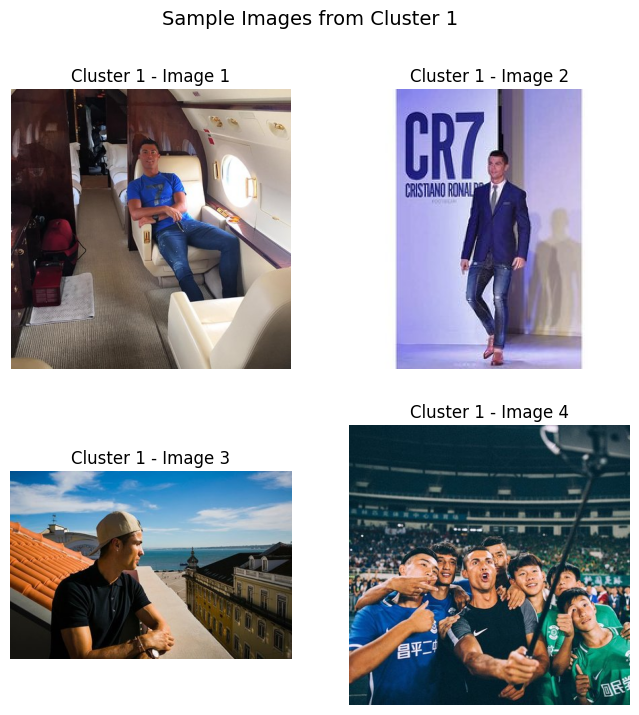

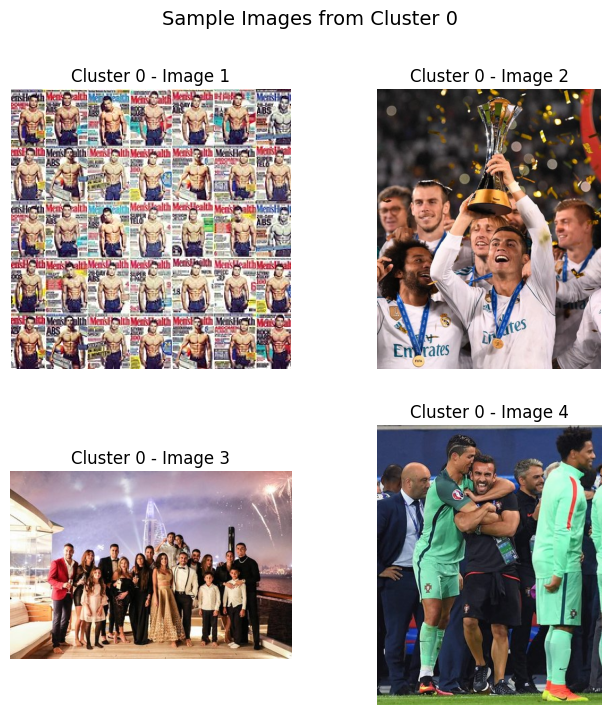

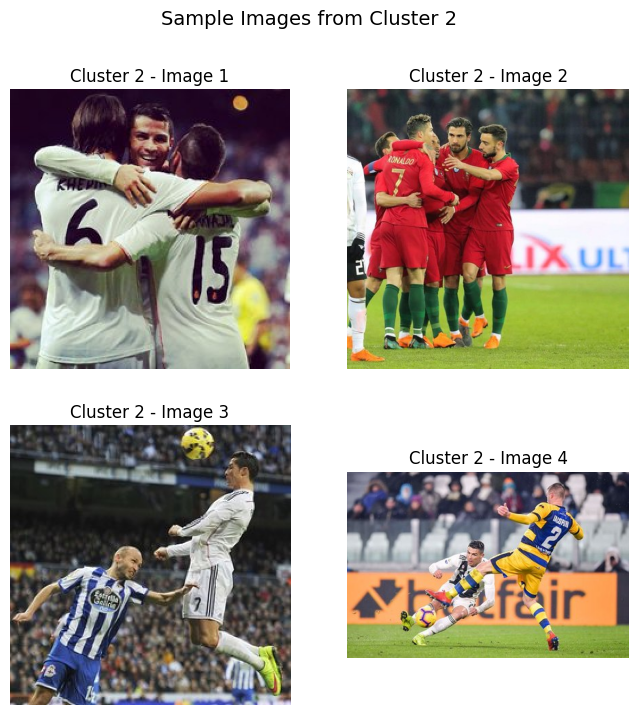

In [ ]:
instructions = '''Describe the common theme of this cluster
of images and give the cluster a title.
Return your answer as nice to read HTML with a "title"
and "description"'''

max_images = 4

for k in df.community.unique():
    image_paths = df[df.community == k]['image_path'].tolist()
    image_paths = random.sample(image_paths, min(max_images, len(image_paths)))
    # Generate the cluster description
    response = jarvis.generate_image_description(image_paths,
                                                 instructions)

    # Display the generated HTML description
    display(HTML(response))


    # Plot the sampled images in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()  # Flatten for easy iteration

    for i, img_path in enumerate(image_paths):
        img = plt.imread(img_path)  # Load image
        axes[i].imshow(img)  # Display image
        axes[i].axis('off')  # Hide axes
        axes[i].set_title(f"Cluster {k} - Image {i+1}")  # Set title

    plt.suptitle(f"Sample Images from Cluster {k}", fontsize=14)
    plt.show()
